In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# Reading input images
path = 'ISIC 2018/ISIC2018_Task3_Training_Input/'

#Dictionary for Image Names
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(path, '*.jpg'))}

#Read Metadata csv
skin_df = pd.read_csv('ISIC 2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image'].map(image_path_dict.get)

In [3]:
image_path_dict

{'ISIC_0024306': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024306.jpg',
 'ISIC_0024307': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024307.jpg',
 'ISIC_0024308': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024308.jpg',
 'ISIC_0024309': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024309.jpg',
 'ISIC_0024310': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024310.jpg',
 'ISIC_0024311': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024311.jpg',
 'ISIC_0024312': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024312.jpg',
 'ISIC_0024313': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024313.jpg',
 'ISIC_0024314': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024314.jpg',
 'ISIC_0024315': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024315.jpg',
 'ISIC_0024316': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024316.jpg',
 'ISIC_0024317': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_0024317.jpg',
 'ISIC_0024318': 'ISIC 2018/ISIC2018_Task3_Training_Input\\ISIC_

In [5]:
skin_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC 2018/ISIC2018_Task3_Training_Input\ISIC_0...


In [6]:
# Checking dataframe info
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   10015 non-null  object 
 1   MEL     10015 non-null  float64
 2   NV      10015 non-null  float64
 3   BCC     10015 non-null  float64
 4   AKIEC   10015 non-null  float64
 5   BKL     10015 non-null  float64
 6   DF      10015 non-null  float64
 7   VASC    10015 non-null  float64
 8   path    10015 non-null  object 
dtypes: float64(7), object(2)
memory usage: 704.3+ KB


In [7]:
# Image Reading and Resizing.
IMAGE_SIZE = 32
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [02:07<00:00, 78.70it/s]


In [8]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 32, 32, 3)


In [9]:
# Creating Target
y = skin_df.iloc[:,1:8]
y

,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
10010,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y = np.array(y)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [11]:
# Splitting the data
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y)

# Normalization
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Splitting training into Train and Validatation sets
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.20,random_state=128,stratify=y_train)

In [17]:
from imblearn.over_sampling import SMOTE
    
sm = SMOTE(random_state=42)
    
rows=len(x_train)
x_train = x_train.reshape(rows,-1)

x_train, y_train = sm.fit_resample(x_train, y_train)

x_train = x_train.reshape(-1,32,32,3)
print(x_train.shape, y_train.shape)

(30037, 32, 32, 3) (30037, 7)


In [19]:
unique, counts = np.unique(y_train.argmax(axis=1), return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 4291]
 [   1 4291]
 [   2 4291]
 [   3 4291]
 [   4 4291]
 [   5 4291]
 [   6 4291]]


In [20]:
# Model Parameters
input_shape = (32, 32, 3)
num_classes = 7

optimizer = Adam(learning_rate=0.001)

epochs = 50
batch_size = 30

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=7,monitor='val_accuracy')

# Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(x_train)

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                        

In [23]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_val,y_val),
                        verbose = 1, callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/50
1002/1002 [==============================] - 215s 213ms/step - loss: 1.2429 - accuracy: 0.5328 - val_loss: 1.0064 - val_accuracy: 0.5839 - lr: 0.0010
Epoch 2/50
1002/1002 [==============================] - 57s 57ms/step - loss: 0.9444 - accuracy: 0.6446 - val_loss: 1.1020 - val_accuracy: 0.5184 - lr: 0.0010
Epoch 3/50
1002/1002 [==============================] - 59s 58ms/step - loss: 0.8447 - accuracy: 0.6858 - val_loss: 1.0255 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 4/50
1002/1002 [==============================] - 60s 60ms/step - loss: 0.7665 - accuracy: 0.7189 - val_loss: 0.8023 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 5/50
1002/1002 [==============================] - 62s 62ms/step - loss: 0.7185 - accuracy: 0.7357 - val_loss: 0.8147 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 6/50
1002/1002 [==============================] - 65s 65ms/step - loss: 0.6753 - accuracy: 0.7506 - val_loss: 0.9110 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 7/50
1002/1002 [======================

In [25]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

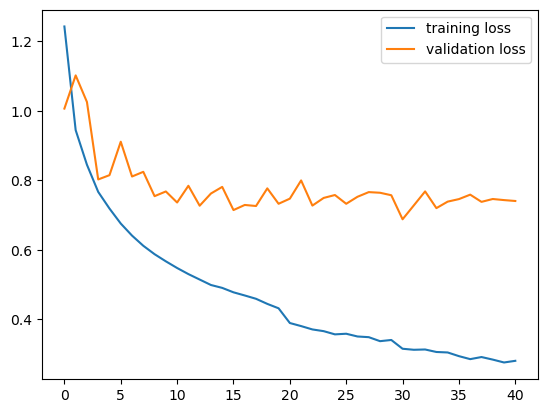

<Figure size 600x400 with 0 Axes>

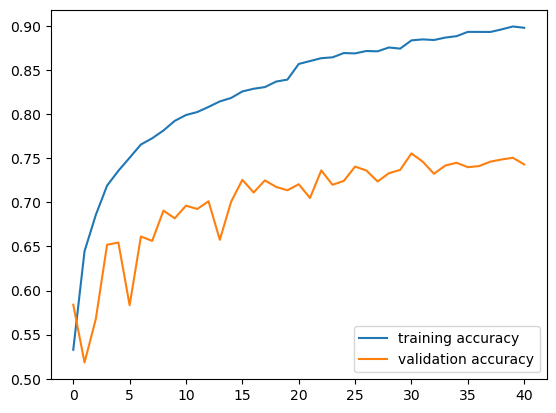

<Figure size 600x400 with 0 Axes>

In [26]:
plt.plot(range(len(loss)), loss, label="training loss")
plt.plot(range(len(val_loss)), val_loss, label="validation loss")
plt.legend(loc="upper right")
plt.figure(figsize=(6,4))
plt.show()
plt.plot(range(len(accuracy)), accuracy, label="training accuracy")
plt.plot(range(len(val_accuracy)), val_accuracy, label="validation accuracy")
plt.legend(loc="lower right")
plt.figure(figsize=(6,4))
plt.show()

In [27]:
model.save('isic_model2.h5')

In [28]:
model.save_weights('isic_model_weights2.h5')

In [29]:
final_model = keras.models.load_model('isic_model2.h5')

In [30]:
final_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
loss_t, accuracy_t = final_model.evaluate(x_train, y_train, verbose=1)
loss_v, accuracy_v = final_model.evaluate(x_val, y_val, verbose=1)
loss, accuracy = final_model.evaluate(x_test, y_test, verbose=1)
predictions = final_model.predict(x_test)

print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

63/63 [==============================] - 1s 17ms/step
Training: accuracy = 0.909845
Validation: accuracy = 0.742982
Test: accuracy = 0.760859


In [32]:
predictions

array([[2.5461218e-03, 9.8426986e-01, 3.2192638e-06, ..., 1.3180183e-02,
        4.6576705e-08, 9.5434671e-10],
       [1.6669037e-02, 5.2831210e-02, 1.8071693e-01, ..., 1.6317635e-03,
        3.8044394e-08, 3.3808374e-07],
       [3.7409868e-02, 8.7182069e-01, 1.9141487e-04, ..., 9.0573385e-02,
        7.4815017e-07, 9.1100583e-10],
       ...,
       [6.9045118e-06, 9.9942279e-01, 1.5843028e-04, ..., 3.7314850e-04,
        2.2541126e-07, 3.2692125e-09],
       [3.1003062e-02, 9.1681600e-01, 1.3554191e-02, ..., 3.4767635e-02,
        1.3236483e-05, 5.0878524e-09],
       [2.6568610e-03, 9.2558312e-01, 1.1883231e-02, ..., 5.7459321e-02,
        4.9824735e-08, 1.2440020e-09]], dtype=float32)

In [33]:
cm = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
cm

array([[ 128,   58,    4,   10,   23,    0,    0],
       [ 112, 1139,   20,   12,   55,    1,    2],
       [   6,    3,   69,   16,    6,    3,    0],
       [   8,    5,   10,   34,    8,    0,    0],
       [  37,   32,   12,   18,  120,    0,    1],
       [   0,    1,    6,    2,    2,   12,    0],
       [   1,    1,    3,    0,    1,    0,   22]], dtype=int64)

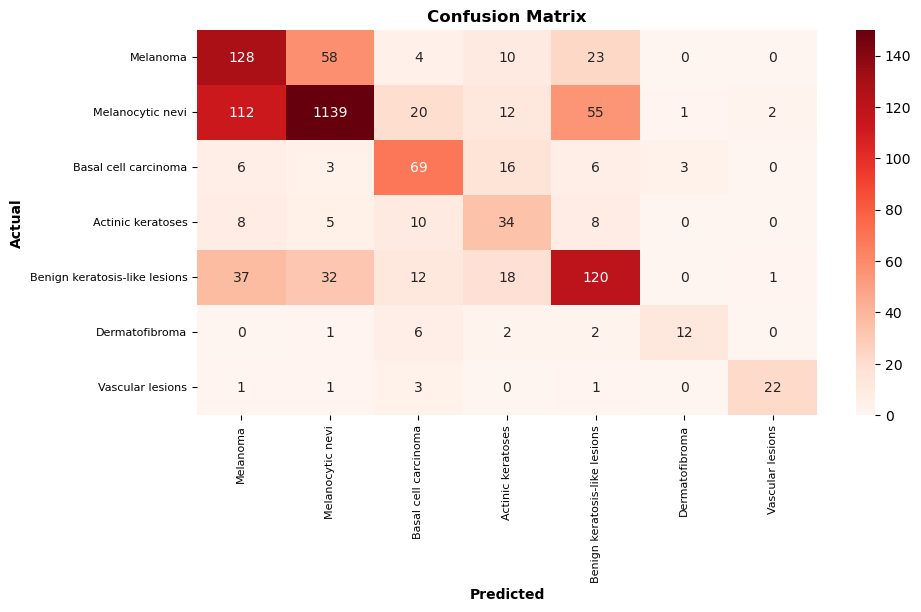

In [39]:
# PLotting Confusion Matrix
categories = ['Melanoma', 'Melanocytic nevi', 'Basal cell carcinoma', 'Actinic keratoses',  'Benign keratosis-like lesions', 'Dermatofibroma', 'Vascular lesions']

CMatrix = pd.DataFrame( (cm) , columns=categories, index =categories)

plt.figure(figsize=(10, 5))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 150,cmap = 'Reds')
ax.set_xlabel('Predicted',fontsize = 10,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize= 8);
ax.set_ylabel('Actual',fontsize = 10,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_title('Confusion Matrix',fontsize = 12,weight = 'bold');
plt.show()

In [35]:
# Calculating accuracy_score, precision_score, recall_score, f1_score using sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test.argmax(axis=1),predictions.argmax(axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1), target_names=categories))


Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.64
Macro Recall: 0.64
Macro F1-score: 0.63

Weighted Precision: 0.79
Weighted Recall: 0.76
Weighted F1-score: 0.77

Classification Report

                               precision    recall  f1-score   support

                     Melanoma       0.44      0.57      0.50       223
             Melanocytic nevi       0.92      0.85      0.88      1341
         Basal cell carcinoma       0.56      0.67      0.61       103
            Actinic keratoses       0.37      0.52      0.43        65
Benign keratosis-like lesions       0.56      0.55      0.55       220
               Dermatofibroma       0.75      0.52      0.62        23
             Vascular lesions       0.88      0.79      0.83        28

                     accuracy                           0.76      2003
                    macro avg       0.64      0.64      0.63      2003
                 weighted avg       0.79      0.76

In [36]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovo = roc_auc_score(y_test, predictions, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, predictions, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(y_test, predictions, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, predictions, multi_class="ovr", average="weighted")

print("One-vs-One ROC AUC scores:\n{:.3f} (Macro)\n{:.3f} " "(Weighted)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.3f} (Macro)\n{:.3f} " "(Weighted)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.929 (Macro)
0.925 (Weighted)
One-vs-Rest ROC AUC scores:
0.929 (Macro)
0.925 (Weighted)


In [37]:
import sklearn.metrics as metrics

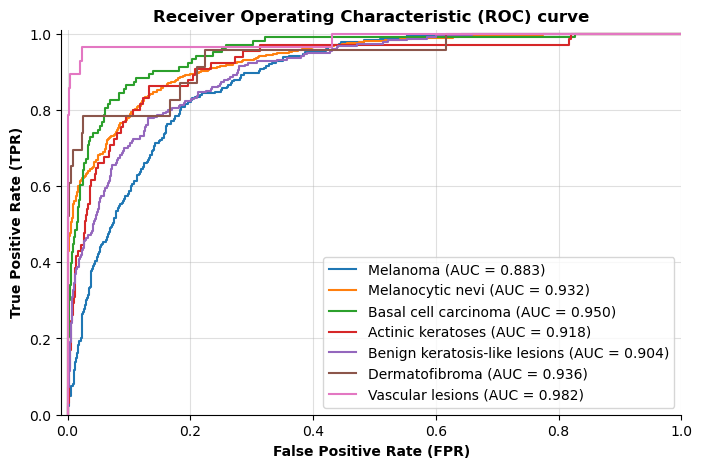

In [38]:
def plot_multiclass_roc(predictions, y_test, n_classes, figsize=(10, 5)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    predict_dummies = predictions
    y_test_dummies = y_test
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:,i], predict_dummies[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([2, 1], [2, 2], 'k--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate (FPR)',fontsize = 10,weight = 'bold')
    ax.set_ylabel('True Positive Rate (TPR)',fontsize = 10,weight = 'bold')
    ax.set_title('Receiver Operating Characteristic (ROC) curve',fontsize = 12,weight = 'bold')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='%s (AUC = %0.3f)' % (categories[i], roc_auc[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(predictions, y_test, num_classes, figsize=(8, 5))